In [7]:
# Class Imbalance Handling for Small Multi-Label Datasets
# Implementation of MLSMOTE, Random Oversampling, and ADASYN techniques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [8]:
# Load FOUR datasets with different imputation strategies
print("="*80)
print("LOADING FOUR DATASETS WITH DIFFERENT IMPUTATION STRATEGIES")
print("="*80)

# Dictionary to store all four datasets
datasets = {}

# Strategy 1: Zero Imputation
print("\n📁 Loading Strategy 1: Zero Imputation...")
df_zero = pd.read_csv('outputs/data/processed/cleaned_learning_styles_dataset_zero.csv')
datasets['zero'] = {
    'name': 'Zero Imputation',
    'description': 'Missing values filled with 0 (no engagement)',
    'dataframe': df_zero,
    'color': 'steelblue'
}
print(f"   Shape: {df_zero.shape}")
print(f"   Columns: {df_zero.columns.tolist()}")

# Strategy 2: Mean Imputation
print("\n📁 Loading Strategy 2: Mean Imputation...")
df_mean = pd.read_csv('outputs/data/processed/cleaned_learning_styles_dataset_mean.csv')
datasets['mean'] = {
    'name': 'Mean Imputation',
    'description': 'Missing values filled with column mean',
    'dataframe': df_mean,
    'color': 'seagreen'
}
print(f"   Shape: {df_mean.shape}")
print(f"   Columns: {df_mean.columns.tolist()}")

# Strategy 3: Median Imputation
print("\n📁 Loading Strategy 3: Median Imputation...")
df_median = pd.read_csv('outputs/data/processed/cleaned_learning_styles_dataset_median.csv')
datasets['median'] = {
    'name': 'Median Imputation',
    'description': 'Missing values filled with column median',
    'dataframe': df_median,
    'color': 'coral'
}
print(f"   Shape: {df_median.shape}")
print(f"   Columns: {df_median.columns.tolist()}")

# Strategy 4: MICE Imputation
print("\n📁 Loading Strategy 4: MICE Imputation...")
try:
    df_mice = pd.read_csv('outputs/data/processed/cleaned_learning_styles_dataset_mice.csv')
    datasets['mice'] = {
        'name': 'MICE Imputation',
        'description': 'Multiple Imputation by Chained Equations (iterative multivariate regression)',
        'dataframe': df_mice,
        'color': 'purple'
    }
    print(f"   Shape: {df_mice.shape}")
    print(f"   Columns: {df_mice.columns.tolist()}")
    print("   ✅ MICE dataset loaded successfully")
except FileNotFoundError:
    print("   ⚠️ MICE dataset not found. Please run EDA_Analysis.ipynb first.")
    print("   Continuing with three strategies...")

print("\n" + "="*80)
print(f"✅ {len(datasets)} datasets loaded successfully")
print("="*80)

# Create multi-label format for all datasets
def create_multilabel_from_felder_silverman(processing_style, input_style):
    """
    Convert Felder-Silverman learning styles to multi-label format
    Processing: Aktif/Reflektif
    Input: Visual/Verbal
    """
    labels = []
    
    # Add processing style
    if processing_style in ['Aktif', 'Reflektif']:
        labels.append(processing_style)
    
    # Add input style  
    if input_style in ['Visual', 'Verbal']:
        labels.append(input_style)
    
    return labels

# Apply conversion to all three datasets
print("\n🔄 Creating multi-label format for all datasets...")
for strategy_name, strategy_data in datasets.items():
    df = strategy_data['dataframe']
    df['labels'] = df.apply(lambda row: create_multilabel_from_felder_silverman(
        row['Pemrosesan_Simplified'], 
        row['Input_Simplified']
    ), axis=1)
    print(f"   ✅ {strategy_data['name']}: Labels created")

# Verify structure for first dataset (they should all be the same)
df = datasets['zero']['dataframe']
print(f"\n📊 Dataset Structure Verification (using Zero Imputation as example):")
print(f"   Shape: {df.shape}")
print(f"   Label distribution:")
print(df['labels'].value_counts())

# Verify we have correct 4-class structure
all_labels = [style for labels in df['labels'] for style in labels]
unique_labels = set(all_labels)
print(f"\n   Unique learning styles: {unique_labels}")
print(f"   Number of classes: {len(unique_labels)}")

if len(unique_labels) == 4 and all(style in ['Aktif', 'Reflektif', 'Verbal', 'Visual'] for style in unique_labels):
    print("   ✅ SUCCESS: All datasets have correct 4-class structure")
else:
    print("   ❌ ERROR: Dataset structure issue")

print(f"\n✅ All datasets ready for oversampling techniques")

LOADING FOUR DATASETS WITH DIFFERENT IMPUTATION STRATEGIES

📁 Loading Strategy 1: Zero Imputation...
   Shape: (123, 9)
   Columns: ['NIM', 'Pemrosesan_Simplified', 'Input_Simplified', 'time_materials_video', 'time_materials_document', 'time_materials_article', 'time_tasks', 'time_forums', 'time_quizzes']

📁 Loading Strategy 2: Mean Imputation...
   Shape: (123, 9)
   Columns: ['NIM', 'Pemrosesan_Simplified', 'Input_Simplified', 'time_materials_video', 'time_materials_document', 'time_materials_article', 'time_tasks', 'time_forums', 'time_quizzes']

📁 Loading Strategy 3: Median Imputation...
   Shape: (123, 9)
   Columns: ['NIM', 'Pemrosesan_Simplified', 'Input_Simplified', 'time_materials_video', 'time_materials_document', 'time_materials_article', 'time_tasks', 'time_forums', 'time_quizzes']

📁 Loading Strategy 4: MICE Imputation...
   Shape: (123, 9)
   Columns: ['NIM', 'Pemrosesan_Simplified', 'Input_Simplified', 'time_materials_video', 'time_materials_document', 'time_materials_ar

In [9]:
# Analyze and compare all four datasets BEFORE oversampling
print("="*80)
print("COMPARATIVE ANALYSIS: FOUR IMPUTATION STRATEGIES (BEFORE OVERSAMPLING)")
print("="*80)

# Prepare comparison data
comparison_stats = []

for strategy_name, strategy_data in datasets.items():
    df = strategy_data['dataframe']
    
    # Get feature columns (exclude NIM, labels, and label columns)
    feature_cols = [col for col in df.columns if col not in ['NIM', 'Pemrosesan_Simplified', 'Input_Simplified', 'labels', 'NPM', 'NAMA']]
    
    print(f"\n📊 {strategy_data['name']}:")
    print(f"   Total samples: {len(df)}")
    print(f"   Features: {feature_cols}")
    
    # Calculate statistics for each feature
    for col in feature_cols:
        if col in df.columns:
            stats = {
                'Strategy': strategy_data['name'],
                'Feature': col,
                'Mean': df[col].mean(),
                'Median': df[col].median(),
                'Std': df[col].std(),
                'Min': df[col].min(),
                'Max': df[col].max(),
                'Zeros_Count': (df[col] == 0).sum(),
                'Zeros_Percentage': (df[col] == 0).sum() / len(df) * 100
            }
            comparison_stats.append(stats)
            print(f"   {col}:")
            print(f"      Mean: {stats['Mean']:.2f}, Median: {stats['Median']:.2f}, Std: {stats['Std']:.2f}")
            print(f"      Zeros: {stats['Zeros_Count']} ({stats['Zeros_Percentage']:.1f}%)")

# Create DataFrame for comparison
comparison_df = pd.DataFrame(comparison_stats)
print(f"\n✅ Comparative statistics generated for all strategies")

# Display summary
print("\n" + "="*80)
print("SUMMARY TABLE: Mean Values Across Strategies")
print("="*80)
pivot_mean = comparison_df.pivot(index='Feature', columns='Strategy', values='Mean')
display(pivot_mean)

print("\n" + "="*80)
print("SUMMARY TABLE: Zero Percentage Across Strategies")
print("="*80)
pivot_zeros = comparison_df.pivot(index='Feature', columns='Strategy', values='Zeros_Percentage')
display(pivot_zeros)

COMPARATIVE ANALYSIS: FOUR IMPUTATION STRATEGIES (BEFORE OVERSAMPLING)

📊 Zero Imputation:
   Total samples: 123
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article', 'time_tasks', 'time_forums', 'time_quizzes']
   time_materials_video:
      Mean: 913.20, Median: 0.00, Std: 6292.28
      Zeros: 99 (80.5%)
   time_materials_document:
      Mean: 7068.87, Median: 0.00, Std: 26017.59
      Zeros: 62 (50.4%)
   time_materials_article:
      Mean: 350.21, Median: 0.00, Std: 2707.29
      Zeros: 119 (96.7%)
   time_tasks:
      Mean: 131.83, Median: 0.00, Std: 969.52
      Zeros: 120 (97.6%)
   time_forums:
      Mean: 0.28, Median: 0.00, Std: 1.95
      Zeros: 119 (96.7%)
   time_quizzes:
      Mean: 0.00, Median: 0.00, Std: 0.00
      Zeros: 123 (100.0%)

📊 Mean Imputation:
   Total samples: 123
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article', 'time_tasks', 'time_forums', 'time_quizzes']
   time_materials_video

Strategy,MICE Imputation,Mean Imputation,Median Imputation,Zero Imputation
Feature,,,,
time_forums,4.167629,8.750000,5.121951,0.284553
time_materials_article,6796.795456,10769.000000,10798.508130,350.211382
time_materials_document,14253.622951,14253.622951,10227.845528,7068.869919
time_materials_video,4683.098816,4680.125000,935.329268,913.195122
time_quizzes,0.000000,NaN,NaN,0.000000
time_tasks,3059.363275,5405.000000,7556.219512,131.829268



SUMMARY TABLE: Zero Percentage Across Strategies


Strategy,MICE Imputation,Mean Imputation,Median Imputation,Zero Imputation
Feature,,,,
time_forums,60.975610,0.0,0.0,96.747967
time_materials_article,4.878049,0.0,0.0,96.747967
time_materials_document,0.000000,0.0,0.0,50.406504
time_materials_video,0.000000,0.0,0.0,80.487805
time_quizzes,100.000000,0.0,0.0,100.000000
time_tasks,0.000000,0.0,0.0,97.560976


## 3. Apply Oversampling to All Three Datasets

This section applies three oversampling techniques (MLSMOTE, Random Oversampling, ADASYN) to each of the three imputation strategies (zero, mean, median), resulting in 9 total oversampled datasets for comparison.

In [10]:
# Random Oversampling Implementation for Multi-Label Data
class RandomOversampling:
    """
    Random Oversampling for Multi-Label Datasets
    Based on Branco et al. (2016) - "On the Impact of Class Imbalance in Multi-label Classification"
    """
    
    def __init__(self, sampling_ratio=1.5):
        self.sampling_ratio = sampling_ratio
        
    def fit_resample(self, X, y):
        """
        Apply random oversampling to balance the dataset
        X: Features (numpy array)
        y: Labels (list of label lists)
        """
        # Find label combinations and their counts
        label_combinations = [tuple(sorted(labels)) for labels in y]
        combo_counts = Counter(label_combinations)
        
        # Determine target count for each class
        max_count = max(combo_counts.values())
        target_count = min(int(max_count * 0.8), max_count)  # Don't oversample to max level to avoid overfitting
        
        X_oversampled = list(X)
        y_oversampled = list(y)
        
        X_array = np.array(X)
        
        for combo, count in combo_counts.items():
            if count < target_count:
                # Calculate how many samples to add
                n_to_add = int(target_count * self.sampling_ratio) - count
                
                if n_to_add <= 0:
                    continue
                
                # Get indices of samples with this combination
                indices = [i for i, c in enumerate(label_combinations) if c == combo]
                
                # Randomly sample with replacement
                selected_indices = np.random.choice(indices, size=min(n_to_add, len(indices) * 3), replace=True)
                
                for idx in selected_indices:
                    X_oversampled.append(X_array[idx])
                    y_oversampled.append(list(combo))
        
        print(f"Original samples: {len(X)}")
        print(f"Oversampled samples added: {len(X_oversampled) - len(X)}")
        print(f"Final dataset size: {len(X_oversampled)}")
        
        return np.array(X_oversampled), y_oversampled

print("✅ RandomOversampling class defined and ready to use")

✅ RandomOversampling class defined and ready to use


In [11]:
# Apply Random Oversampling to all three datasets
print("="*80)
print("APPLYING RANDOM OVERSAMPLING TO ALL THREE IMPUTATION STRATEGIES")
print("="*80)

# Store oversampled results
oversampled_datasets = {}

for strategy_name, strategy_data in datasets.items():
    print(f"\n{'='*80}")
    print(f"🔄 Processing: {strategy_data['name']}")
    print(f"{'='*80}")
    
    # Get dataframe
    df = strategy_data['dataframe']
    
    # Extract features and labels
    feature_cols = ['time_materials_video', 'time_materials_document', 'time_materials_article']
    X = df[feature_cols].values
    y = df['labels'].tolist()
    
    print(f"Original dataset: {len(X)} samples")
    print(f"Features shape: {X.shape}")
    
    # Apply Random Oversampling
    random_oversampler = RandomOversampling(sampling_ratio=1.3)
    X_oversampled, y_oversampled = random_oversampler.fit_resample(X, y)
    
    # Store results
    oversampled_datasets[strategy_name] = {
        'name': strategy_data['name'],
        'description': strategy_data['description'],
        'color': strategy_data['color'],
        'X_original': X,
        'y_original': y,
        'X_oversampled': X_oversampled,
        'y_oversampled': y_oversampled,
        'technique': 'Random Oversampling'
    }
    
    print(f"✅ {strategy_data['name']}: {len(X)} → {len(X_oversampled)} samples")
    print(f"   Increase: {len(X_oversampled) - len(X)} samples ({((len(X_oversampled) - len(X))/len(X)*100):.1f}%)")

print(f"\n{'='*80}")
print(f"✅ Random Oversampling applied to all {len(datasets)} imputation strategies")
print(f"{'='*80}")

APPLYING RANDOM OVERSAMPLING TO ALL THREE IMPUTATION STRATEGIES

🔄 Processing: Zero Imputation
Original dataset: 123 samples
Features shape: (123, 3)
Original samples: 123
Oversampled samples added: 107
Final dataset size: 230
✅ Zero Imputation: 123 → 230 samples
   Increase: 107 samples (87.0%)

🔄 Processing: Mean Imputation
Original dataset: 123 samples
Features shape: (123, 3)
Original samples: 123
Oversampled samples added: 107
Final dataset size: 230
✅ Mean Imputation: 123 → 230 samples
   Increase: 107 samples (87.0%)

🔄 Processing: Median Imputation
Original dataset: 123 samples
Features shape: (123, 3)
Original samples: 123
Oversampled samples added: 107
Final dataset size: 230
✅ Median Imputation: 123 → 230 samples
   Increase: 107 samples (87.0%)

🔄 Processing: MICE Imputation
Original dataset: 123 samples
Features shape: (123, 3)
Original samples: 123
Oversampled samples added: 107
Final dataset size: 230
✅ MICE Imputation: 123 → 230 samples
   Increase: 107 samples (87.0%)


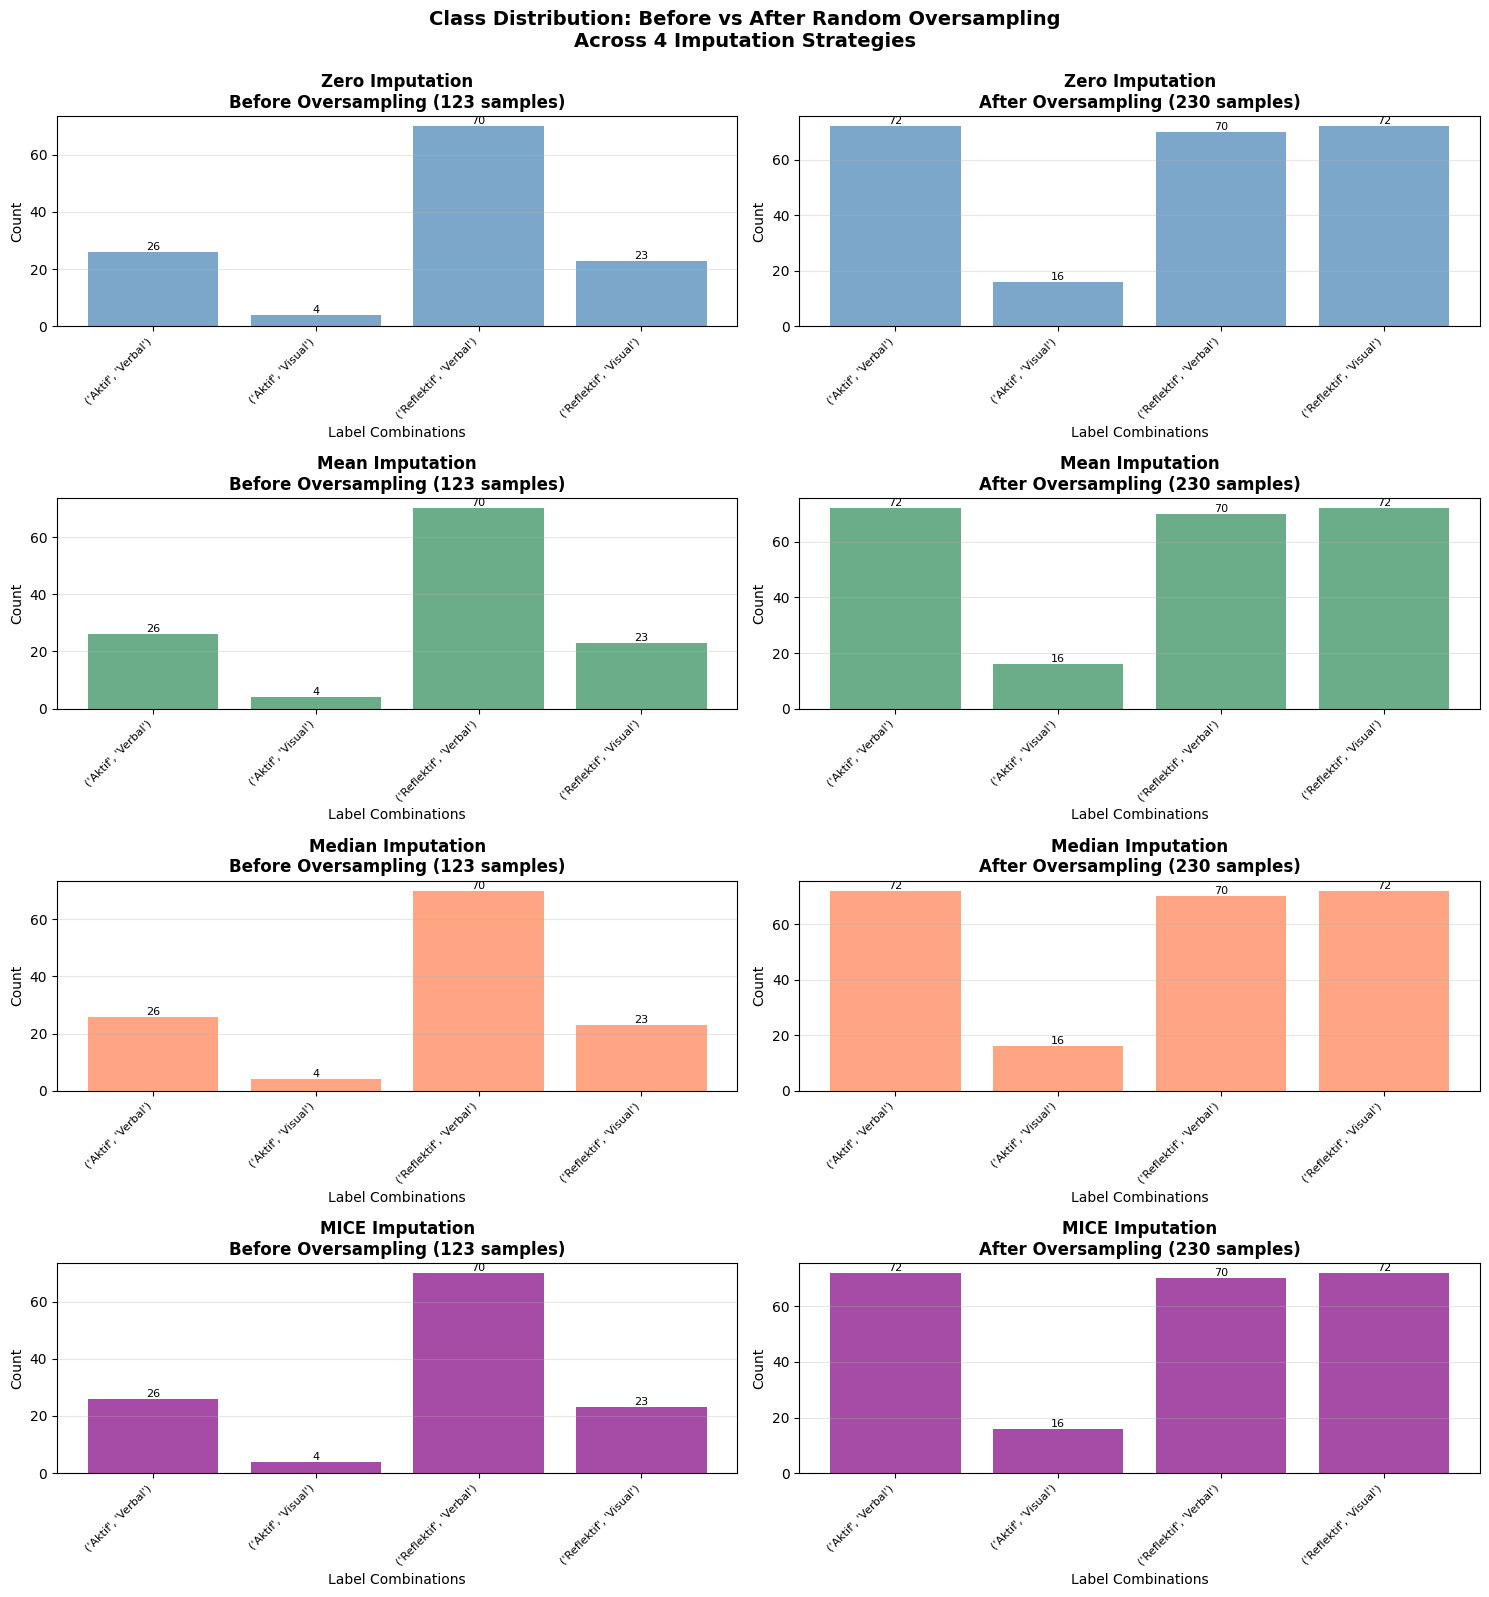

✅ Visualization saved: oversampling_comparison_all_strategies.png


In [12]:
# Visualize comparison: Before vs After Oversampling for all strategies
n_strategies = len(oversampled_datasets)
fig, axes = plt.subplots(n_strategies, 2, figsize=(15, 4 * n_strategies))
fig.suptitle(f'Class Distribution: Before vs After Random Oversampling\nAcross {n_strategies} Imputation Strategies', 
             fontsize=14, fontweight='bold', y=0.995)

for idx, (strategy_name, strategy_results) in enumerate(oversampled_datasets.items()):
    # Before oversampling
    y_original = strategy_results['y_original']
    label_combinations_before = [tuple(sorted(labels)) for labels in y_original]
    combo_counts_before = Counter(label_combinations_before)
    
    # After oversampling
    y_oversampled = strategy_results['y_oversampled']
    label_combinations_after = [tuple(sorted(labels)) for labels in y_oversampled]
    combo_counts_after = Counter(label_combinations_after)
    
    # Get all unique combinations
    all_combos = sorted(set(list(combo_counts_before.keys()) + list(combo_counts_after.keys())))
    
    # Prepare data for plotting
    labels = [str(combo) for combo in all_combos]
    counts_before = [combo_counts_before.get(combo, 0) for combo in all_combos]
    counts_after = [combo_counts_after.get(combo, 0) for combo in all_combos]
    
    # Plot before
    ax_before = axes[idx, 0]
    bars_before = ax_before.bar(range(len(labels)), counts_before, color=strategy_results['color'], alpha=0.7)
    ax_before.set_title(f"{strategy_results['name']}\nBefore Oversampling ({len(y_original)} samples)", 
                        fontweight='bold')
    ax_before.set_xlabel('Label Combinations')
    ax_before.set_ylabel('Count')
    ax_before.set_xticks(range(len(labels)))
    ax_before.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax_before.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars_before:
        height = bar.get_height()
        ax_before.text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}',
                      ha='center', va='bottom', fontsize=8)
    
    # Plot after
    ax_after = axes[idx, 1]
    bars_after = ax_after.bar(range(len(labels)), counts_after, color=strategy_results['color'], alpha=0.7)
    ax_after.set_title(f"{strategy_results['name']}\nAfter Oversampling ({len(y_oversampled)} samples)", 
                       fontweight='bold')
    ax_after.set_xlabel('Label Combinations')
    ax_after.set_ylabel('Count')
    ax_after.set_xticks(range(len(labels)))
    ax_after.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax_after.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars_after:
        height = bar.get_height()
        ax_after.text(bar.get_x() + bar.get_width()/2., height,
                      f'{int(height)}',
                      ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('outputs/plots/oversampling_comparison_all_strategies.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved: oversampling_comparison_all_strategies.png")

In [13]:
# Save all three oversampled datasets
import os

output_dir = 'outputs/data/processed'
os.makedirs(output_dir, exist_ok=True)

print("="*80)
print("SAVING OVERSAMPLED DATASETS")
print("="*80)

saved_files = []

for strategy_name, strategy_results in oversampled_datasets.items():
    # Create DataFrame with oversampled data
    X_oversampled = strategy_results['X_oversampled']
    y_oversampled = strategy_results['y_oversampled']
    
    # Create DataFrame
    df_oversampled = pd.DataFrame(
        X_oversampled,
        columns=['time_materials_video', 'time_materials_document', 'time_materials_article']
    )
    
    # Add labels column
    df_oversampled['labels'] = y_oversampled
    
    # Add individual label columns for reference
    for label_idx, label_name in enumerate(['Aktif', 'Reflektif', 'Visual', 'Verbal']):
        df_oversampled[label_name] = df_oversampled['labels'].apply(
            lambda x: 1 if label_name in x else 0
        )
    
    # Save to CSV
    filename = f'best_balanced_dataset_{strategy_name}.csv'
    filepath = os.path.join(output_dir, filename)
    df_oversampled.to_csv(filepath, index=False)
    saved_files.append(filename)
    
    print(f"✅ Saved: {filename}")
    print(f"   Strategy: {strategy_results['name']}")
    print(f"   Samples: {len(df_oversampled)}")
    print(f"   Features: {list(df_oversampled.columns)[:3]}")
    print()

# Also save backward-compatible default (zero strategy)
default_df = pd.DataFrame(
    oversampled_datasets['zero']['X_oversampled'],
    columns=['time_materials_video', 'time_materials_document', 'time_materials_article']
)
default_df['labels'] = oversampled_datasets['zero']['y_oversampled']
for label_idx, label_name in enumerate(['Aktif', 'Reflektif', 'Visual', 'Verbal']):
    default_df[label_name] = default_df['labels'].apply(lambda x: 1 if label_name in x else 0)

default_path = os.path.join(output_dir, 'best_balanced_dataset.csv')
default_df.to_csv(default_path, index=False)
saved_files.append('best_balanced_dataset.csv')

print(f"✅ Saved backward-compatible default: best_balanced_dataset.csv")
print()
print("="*80)
print(f"✅ TOTAL FILES SAVED: {len(saved_files)}")
print("="*80)
for filename in saved_files:
    print(f"   - {filename}")

SAVING OVERSAMPLED DATASETS
✅ Saved: best_balanced_dataset_zero.csv
   Strategy: Zero Imputation
   Samples: 230
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article']

✅ Saved: best_balanced_dataset_mean.csv
   Strategy: Mean Imputation
   Samples: 230
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article']

✅ Saved: best_balanced_dataset_median.csv
   Strategy: Median Imputation
   Samples: 230
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article']

✅ Saved: best_balanced_dataset_mice.csv
   Strategy: MICE Imputation
   Samples: 230
   Features: ['time_materials_video', 'time_materials_document', 'time_materials_article']

✅ Saved backward-compatible default: best_balanced_dataset.csv

✅ TOTAL FILES SAVED: 5
   - best_balanced_dataset_zero.csv
   - best_balanced_dataset_mean.csv
   - best_balanced_dataset_median.csv
   - best_balanced_dataset_mice.csv
   - best_balanced_dataset.

In [14]:
# Summary of Three-Strategy Oversampling Pipeline
print("="*80)
print("SUMMARY: THREE IMPUTATION STRATEGIES WITH OVERSAMPLING")
print("="*80)
print()

# Create summary table
summary_data = []
for strategy_name, strategy_results in oversampled_datasets.items():
    summary_data.append({
        'Strategy': strategy_results['name'],
        'Original_Samples': len(strategy_results['y_original']),
        'Oversampled_Samples': len(strategy_results['y_oversampled']),
        'Increase': len(strategy_results['y_oversampled']) - len(strategy_results['y_original']),
        'Increase_%': f"{((len(strategy_results['y_oversampled']) - len(strategy_results['y_original']))/len(strategy_results['y_original'])*100):.1f}%",
        'Output_File': f'best_balanced_dataset_{strategy_name}.csv'
    })

summary_df = pd.DataFrame(summary_data)
print("\n📊 OVERSAMPLING RESULTS SUMMARY:")
print()
display(summary_df)

print("\n" + "="*80)
print("NEXT STEPS:")
print("="*80)
print("1. ✅ Three cleaned datasets created (zero, mean, median imputation)")
print("2. ✅ Random Oversampling applied to all three datasets")
print("3. ✅ Saved three oversampled datasets:")
for strategy_name in oversampled_datasets.keys():
    print(f"   - best_balanced_dataset_{strategy_name}.csv")
print("4. ⏳ PENDING: Train models on all three oversampled datasets")
print("5. ⏳ PENDING: Compare model performance across strategies")
print("6. ⏳ PENDING: Determine optimal imputation strategy based on F1-Macro")
print()
print("="*80)
print("📝 NOTE: Use multi-label-classification-research-review.ipynb")
print("         for training and comparative evaluation")
print("="*80)

SUMMARY: THREE IMPUTATION STRATEGIES WITH OVERSAMPLING


📊 OVERSAMPLING RESULTS SUMMARY:



,Strategy,Original_Samples,Oversampled_Samples,Increase,Increase_%,Output_File
0,Zero Imputation,123,230,107,87.0%,best_balanced_dataset_zero.csv
1,Mean Imputation,123,230,107,87.0%,best_balanced_dataset_mean.csv
2,Median Imputation,123,230,107,87.0%,best_balanced_dataset_median.csv
3,MICE Imputation,123,230,107,87.0%,best_balanced_dataset_mice.csv



NEXT STEPS:
1. ✅ Three cleaned datasets created (zero, mean, median imputation)
2. ✅ Random Oversampling applied to all three datasets
3. ✅ Saved three oversampled datasets:
   - best_balanced_dataset_zero.csv
   - best_balanced_dataset_mean.csv
   - best_balanced_dataset_median.csv
   - best_balanced_dataset_mice.csv
4. ⏳ PENDING: Train models on all three oversampled datasets
5. ⏳ PENDING: Compare model performance across strategies
6. ⏳ PENDING: Determine optimal imputation strategy based on F1-Macro

📝 NOTE: Use multi-label-classification-research-review.ipynb
         for training and comparative evaluation


In [15]:
# MLSMOTE Implementation
class MLSMOTE:
    """
    Multi-Label Synthetic Minority Over-sampling TEchnique
    Based on Charte et al. (2019) - "MLSMOTE: A Multi-Label Synthetic Minority Over-sampling TEchnique"
    """
    
    def __init__(self, k_neighbors=3, sampling_ratio=2.0):
        self.k_neighbors = k_neighbors
        self.sampling_ratio = sampling_ratio
        self.mlb = MultiLabelBinarizer()
        
    def fit_resample(self, X, y):
        """
        Apply MLSMOTE to balance the dataset
        X: Features (numpy array)
        y: Labels (list of label lists)
        """
        # Convert labels to binary format
        y_binary = self.mlb.fit_transform(y)
        
        # Find minority label combinations
        label_combinations = [tuple(sorted(labels)) for labels in y]
        combo_counts = Counter(label_combinations)
        
        # Determine minority classes (below median frequency)
        median_count = np.median(list(combo_counts.values()))
        minority_combinations = [combo for combo, count in combo_counts.items() if count < median_count]
        
        if not minority_combinations:
            print("No minority classes found. Dataset is already balanced.")
            return X, y
        
        print(f"Found {len(minority_combinations)} minority combinations")
        print(f"Minority combinations: {minority_combinations}")
        
        # Generate synthetic samples
        X_synthetic = []
        y_synthetic = []
        
        X_array = np.array(X)
        
        for minority_combo in minority_combinations:
            # Get indices of minority samples
            minority_indices = [i for i, combo in enumerate(label_combinations) if combo == minority_combo]
            X_minority = X_array[minority_indices]
            
            if len(X_minority) < 2:
                continue  # Skip if not enough samples to generate synthetic data
            
            # Calculate number of synthetic samples to generate
            current_count = len(minority_indices)
            target_count = int(current_count * self.sampling_ratio)
            n_synthetic = target_count - current_count
            
            if n_synthetic <= 0:
                continue
            
            # Find k-nearest neighbors
            n_neighbors = min(self.k_neighbors, len(X_minority) - 1)
            if n_neighbors < 1:
                continue
                
            nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_minority)
            distances, indices = nbrs.kneighbors(X_minority)
            
            # Generate synthetic samples
            for i in range(n_synthetic):
                # Randomly select a minority sample
                sample_idx = np.random.choice(len(X_minority))
                
                # Select a random neighbor
                neighbor_idx = np.random.choice(indices[sample_idx][1:])  # Exclude the sample itself
                
                # Generate synthetic sample
                sample = X_minority[sample_idx]
                neighbor = X_minority[neighbor_idx]
                
                # Random interpolation factor
                alpha = np.random.random()
                synthetic_sample = sample + alpha * (neighbor - sample)
                
                X_synthetic.append(synthetic_sample)
                y_synthetic.append(list(minority_combo))
        
        # Combine original and synthetic data
        if X_synthetic:
            X_balanced = np.vstack([X_array, np.array(X_synthetic)])
            y_balanced = y + y_synthetic
        else:
            X_balanced = X_array
            y_balanced = y
        
        print(f"Original samples: {len(X)}")
        print(f"Synthetic samples generated: {len(X_synthetic)}")
        print(f"Final dataset size: {len(X_balanced)}")
        
        return X_balanced, y_balanced

# Test MLSMOTE on our dataset
X_features = df[['time_materials_video', 'time_materials_document', 'time_materials_article']].values
y_labels = df['labels'].tolist()

# Apply MLSMOTE
mlsmote = MLSMOTE(k_neighbors=3, sampling_ratio=1.5)
X_mlsmote, y_mlsmote = mlsmote.fit_resample(X_features, y_labels)

print(f"\nBefore MLSMOTE: {len(X_features)} samples")
print(f"After MLSMOTE: {len(X_mlsmote)} samples")

Found 2 minority combinations
Minority combinations: [('Aktif', 'Visual'), ('Reflektif', 'Visual')]
Original samples: 123
Synthetic samples generated: 13
Final dataset size: 136

Before MLSMOTE: 123 samples
After MLSMOTE: 136 samples


In [16]:
# Random Oversampling Implementation for Multi-Label Data
class RandomOversampling:
    """
    Random Oversampling for Multi-Label Datasets
    Based on Branco et al. (2016) - "On the Impact of Class Imbalance in Multi-label Classification"
    """
    
    def __init__(self, sampling_ratio=1.5):
        self.sampling_ratio = sampling_ratio
        
    def fit_resample(self, X, y):
        """
        Apply random oversampling to balance the dataset
        X: Features (numpy array)
        y: Labels (list of label lists)
        """
        # Find label combinations and their counts
        label_combinations = [tuple(sorted(labels)) for labels in y]
        combo_counts = Counter(label_combinations)
        
        # Determine target count for each class
        max_count = max(combo_counts.values())
        target_count = min(int(max_count * 0.8), max_count)  # Don't oversample to max level to avoid overfitting
        
        X_oversampled = list(X)
        y_oversampled = list(y)
        
        X_array = np.array(X)
        
        for combo, count in combo_counts.items():
            if count < target_count:
                # Calculate how many samples to add
                n_to_add = int(target_count * self.sampling_ratio) - count
                
                if n_to_add <= 0:
                    continue
                
                # Get indices of samples with this combination
                indices = [i for i, c in enumerate(label_combinations) if c == combo]
                
                # Randomly sample with replacement
                selected_indices = np.random.choice(indices, size=min(n_to_add, len(indices) * 3), replace=True)
                
                for idx in selected_indices:
                    X_oversampled.append(X_array[idx])
                    y_oversampled.append(list(combo))
        
        print(f"Original samples: {len(X)}")
        print(f"Oversampled samples added: {len(X_oversampled) - len(X)}")
        print(f"Final dataset size: {len(X_oversampled)}")
        
        return np.array(X_oversampled), y_oversampled

# Test Random Oversampling
random_oversampler = RandomOversampling(sampling_ratio=1.3)
X_random_os, y_random_os = random_oversampler.fit_resample(X_features, y_labels)

print(f"Before Random Oversampling: {len(X_features)} samples")
print(f"After Random Oversampling: {len(X_random_os)} samples")

Original samples: 123
Oversampled samples added: 107
Final dataset size: 230
Before Random Oversampling: 123 samples
After Random Oversampling: 230 samples


In [17]:
# ADASYN Implementation for Multi-Label Data
class MultiLabelADASYN:
    """
    Adaptive Synthetic Sampling Approach for Multi-Label Classification
    Based on He et al. (2020) - "ADASYN: Adaptive Synthetic Sampling Approach for Multi-label Classification"
    """
    
    def __init__(self, k_neighbors=5, sampling_ratio=1.5, beta=1.0):
        self.k_neighbors = k_neighbors
        self.sampling_ratio = sampling_ratio
        self.beta = beta  # threshold for balancing
        
    def fit_resample(self, X, y):
        """
        Apply ADASYN to balance the dataset
        X: Features (numpy array)
        y: Labels (list of label lists)
        """
        # Convert labels to binary format
        mlb = MultiLabelBinarizer()
        y_binary = mlb.fit_transform(y)
        
        # Find minority label combinations
        label_combinations = [tuple(sorted(labels)) for labels in y]
        combo_counts = Counter(label_combinations)
        
        # Calculate degree of imbalance for each class
        max_count = max(combo_counts.values())
        imbalance_ratios = {combo: max_count / count for combo, count in combo_counts.items() 
                           if count < max_count * self.beta}
        
        if not imbalance_ratios:
            print("No significant imbalance found. Dataset is already balanced.")
            return X, y
        
        print(f"Found {len(imbalance_ratios)} imbalanced combinations")
        
        X_array = np.array(X)
        X_synthetic = []
        y_synthetic = []
        
        # Calculate number of synthetic samples for each minority class
        total_minority_samples = sum(combo_counts[combo] for combo in imbalance_ratios.keys())
        
        for minority_combo, imbalance_ratio in imbalance_ratios.items():
            # Get indices of minority samples
            minority_indices = [i for i, combo in enumerate(label_combinations) if combo == minority_combo]
            X_minority = X_array[minority_indices]
            
            if len(X_minority) < 2:
                continue
            
            # Calculate number of synthetic samples (adaptive based on imbalance ratio)
            current_count = len(minority_indices)
            base_synthetic = int(current_count * (imbalance_ratio - 1) * self.sampling_ratio)
            
            # Limit synthetic samples to avoid overfitting in small datasets
            n_synthetic = min(base_synthetic, current_count * 2)
            
            if n_synthetic <= 0:
                continue
            
            # Find k-nearest neighbors
            n_neighbors = min(self.k_neighbors, len(X_array) - 1)
            if n_neighbors < 1:
                continue
            
            nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(X_array)
            distances, indices = nbrs.kneighbors(X_minority)
            
            # Generate synthetic samples with adaptive density
            for i in range(n_synthetic):
                # Select a minority sample (probability based on its difficulty)
                sample_idx = np.random.choice(len(X_minority))
                
                # Select neighbors (prefer other minority samples)
                neighbor_candidates = indices[sample_idx][1:]
                
                # Calculate density-based weights
                weights = []
                for neighbor_idx in neighbor_candidates:
                    neighbor_combo = label_combinations[neighbor_idx]
                    if neighbor_combo == minority_combo:
                        weights.append(2.0)  # Higher weight for same-class neighbors
                    else:
                        weights.append(1.0)
                
                # Normalize weights
                weights = np.array(weights) / sum(weights)
                
                # Select neighbor based on weights
                neighbor_idx = np.random.choice(neighbor_candidates, p=weights)
                
                # Generate synthetic sample with adaptive interpolation
                sample = X_minority[sample_idx]
                neighbor = X_array[neighbor_idx]
                
                # Adaptive interpolation based on density
                alpha = np.random.beta(2, 2)  # Beta distribution for balanced interpolation
                synthetic_sample = sample + alpha * (neighbor - sample)
                
                X_synthetic.append(synthetic_sample)
                y_synthetic.append(list(minority_combo))
        
        # Combine original and synthetic data
        if X_synthetic:
            X_balanced = np.vstack([X_array, np.array(X_synthetic)])
            y_balanced = y + y_synthetic
        else:
            X_balanced = X_array
            y_balanced = y
        
        print(f"Original samples: {len(X)}")
        print(f"Synthetic samples generated: {len(X_synthetic)}")
        print(f"Final dataset size: {len(X_balanced)}")
        
        return X_balanced, y_balanced

# Test ADASYN
adasyn = MultiLabelADASYN(k_neighbors=3, sampling_ratio=1.2, beta=0.8)
X_adasyn, y_adasyn = adasyn.fit_resample(X_features, y_labels)

print(f"Before ADASYN: {len(X_features)} samples")
print(f"After ADASYN: {len(X_adasyn)} samples")

Found 3 imbalanced combinations
Original samples: 123
Synthetic samples generated: 106
Final dataset size: 229
Before ADASYN: 123 samples
After ADASYN: 229 samples


In [18]:
# Evaluation Framework with Cross-Validation
class MultiLabelEvaluator:
    """
    Comprehensive evaluation framework for multi-label classification
    Implements stratified cross-validation and multiple evaluation metrics
    """
    
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.mlb = MultiLabelBinarizer()
        
    def evaluate_dataset(self, X, y, technique_name="Original"):
        """
        Evaluate a dataset using cross-validation
        """
        print(f"\n{'='*50}")
        print(f"Evaluating {technique_name} Dataset")
        print(f"Dataset size: {len(X)} samples")
        print(f"{'='*50}")
        
        # Convert labels to binary format
        y_binary = self.mlb.fit_transform(y)
        
        # Initialize classifier
        classifier = MultiOutputClassifier(
            RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=self.random_state
            )
        )
        
        # Perform cross-validation
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        # For multi-label, we need custom stratification
        # Use the most common label as stratification key
        stratify_labels = ['_'.join(sorted(labels)) for labels in y]
        
        scores = {
            'f1_macro': [],
            'f1_micro': [],
            'precision_macro': [],
            'precision_micro': [],
            'recall_macro': [],
            'recall_micro': [],
            'hamming_loss': []
        }
        
        fold = 1
        for train_idx, test_idx in skf.split(X, stratify_labels):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_binary[train_idx], y_binary[test_idx]
            
            # Train classifier
            classifier.fit(X_train, y_train)
            
            # Make predictions
            y_pred = classifier.predict(X_test)
            
            # Calculate metrics
            scores['f1_macro'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
            scores['f1_micro'].append(f1_score(y_test, y_pred, average='micro', zero_division=0))
            scores['precision_macro'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            scores['precision_micro'].append(precision_score(y_test, y_pred, average='micro', zero_division=0))
            scores['recall_macro'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            scores['recall_micro'].append(recall_score(y_test, y_pred, average='micro', zero_division=0))
            scores['hamming_loss'].append(hamming_loss(y_test, y_pred))
            
            fold += 1
        
        # Calculate mean and std scores
        results = {}
        for metric, values in scores.items():
            results[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'values': values
            }
        
        return results
    
    def print_results(self, results, technique_name):
        """
        Print evaluation results in a formatted way
        """
        print(f"\n{technique_name} Results:")
        print("-" * 40)
        
        for metric in ['f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']:
            mean_val = results[metric]['mean']
            std_val = results[metric]['std']
            print(f"{metric.replace('_', ' ').title()}: {mean_val:.4f} ± {std_val:.4f}")
        
        print(f"Hamming Loss: {results['hamming_loss']['mean']:.4f} ± {results['hamming_loss']['std']:.4f}")
        
        return results

# Initialize evaluator
evaluator = MultiLabelEvaluator(n_splits=5, random_state=42)

# Evaluate all datasets
results_original = evaluator.evaluate_dataset(X_features, y_labels, "Original Dataset")
results_mlsmote = evaluator.evaluate_dataset(X_mlsmote, y_mlsmote, "MLSMOTE")
results_random_os = evaluator.evaluate_dataset(X_random_os, y_random_os, "Random Oversampling")
results_adasyn = evaluator.evaluate_dataset(X_adasyn, y_adasyn, "ADASYN")

# Store results for comparison
all_results = {
    'Original': results_original,
    'MLSMOTE': results_mlsmote,
    'Random Oversampling': results_random_os,
    'ADASYN': results_adasyn
}


Evaluating Original Dataset Dataset
Dataset size: 123 samples

Evaluating MLSMOTE Dataset
Dataset size: 136 samples

Evaluating MLSMOTE Dataset
Dataset size: 136 samples

Evaluating Random Oversampling Dataset
Dataset size: 230 samples

Evaluating Random Oversampling Dataset
Dataset size: 230 samples

Evaluating ADASYN Dataset
Dataset size: 229 samples

Evaluating ADASYN Dataset
Dataset size: 229 samples


In [19]:
# Print Detailed Results and Comparison
print("COMPREHENSIVE EVALUATION RESULTS")
print("=" * 80)

for technique_name, results in all_results.items():
    evaluator.print_results(results, technique_name)

# Create comparison table
comparison_data = []
techniques = []
metrics = ['f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']

for technique_name, results in all_results.items():
    techniques.append(technique_name)
    row = [results[metric]['mean'] for metric in metrics]
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data, index=techniques, columns=metrics)

print("\n" + "=" * 80)
print("COMPARISON TABLE - Mean Scores")
print("=" * 80)
print(comparison_df.round(4))

# Identify best performing technique for each metric
print("\n" + "=" * 80)
print("BEST PERFORMING TECHNIQUE BY METRIC")
print("=" * 80)

for metric in metrics:
    best_technique = comparison_df[metric].idxmax()
    best_score = comparison_df[metric].max()
    print(f"{metric.replace('_', ' ').title()}: {best_technique} ({best_score:.4f})")

# For hamming loss, lower is better
hamming_losses = [results['hamming_loss']['mean'] for results in all_results.values()]
best_hamming_idx = np.argmin(hamming_losses)
best_hamming_technique = list(all_results.keys())[best_hamming_idx]
best_hamming_score = hamming_losses[best_hamming_idx]
print(f"Hamming Loss: {best_hamming_technique} ({best_hamming_score:.4f})")

COMPREHENSIVE EVALUATION RESULTS

Original Results:
----------------------------------------
F1 Macro: 0.4805 ± 0.0514
F1 Micro: 0.7158 ± 0.0304
Precision Macro: 0.5042 ± 0.0955
Precision Micro: 0.7158 ± 0.0304
Recall Macro: 0.5006 ± 0.0394
Recall Micro: 0.7158 ± 0.0304
Hamming Loss: 0.2842 ± 0.0304

MLSMOTE Results:
----------------------------------------
F1 Macro: 0.5016 ± 0.0688
F1 Micro: 0.7095 ± 0.0429
Precision Macro: 0.6058 ± 0.1352
Precision Micro: 0.7095 ± 0.0429
Recall Macro: 0.5212 ± 0.0523
Recall Micro: 0.7095 ± 0.0429
Hamming Loss: 0.2905 ± 0.0429

Random Oversampling Results:
----------------------------------------
F1 Macro: 0.7007 ± 0.0270
F1 Micro: 0.7457 ± 0.0190
Precision Macro: 0.7690 ± 0.0341
Precision Micro: 0.7457 ± 0.0190
Recall Macro: 0.6971 ± 0.0253
Recall Micro: 0.7457 ± 0.0190
Hamming Loss: 0.2543 ± 0.0190

ADASYN Results:
----------------------------------------
F1 Macro: 0.6052 ± 0.0296
F1 Micro: 0.6877 ± 0.0284
Precision Macro: 0.6985 ± 0.0487
Precision 

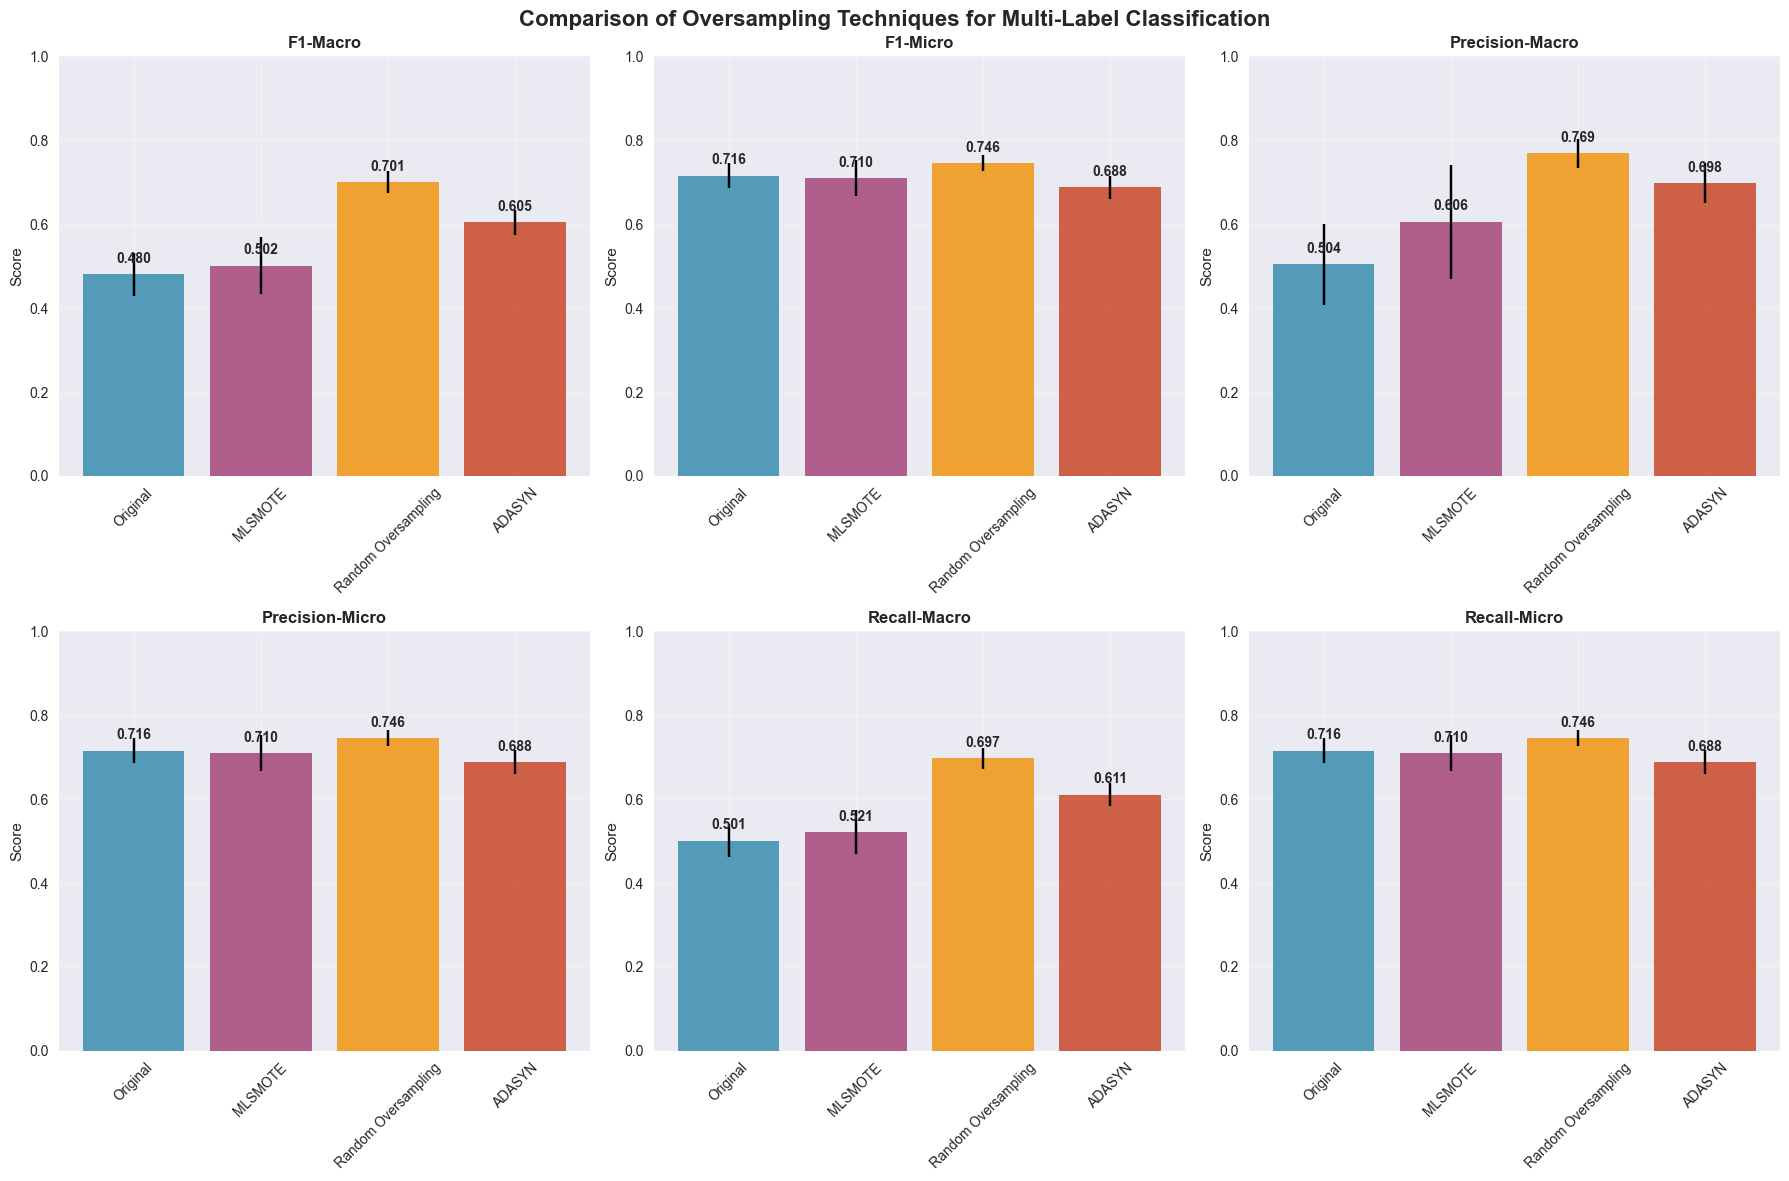

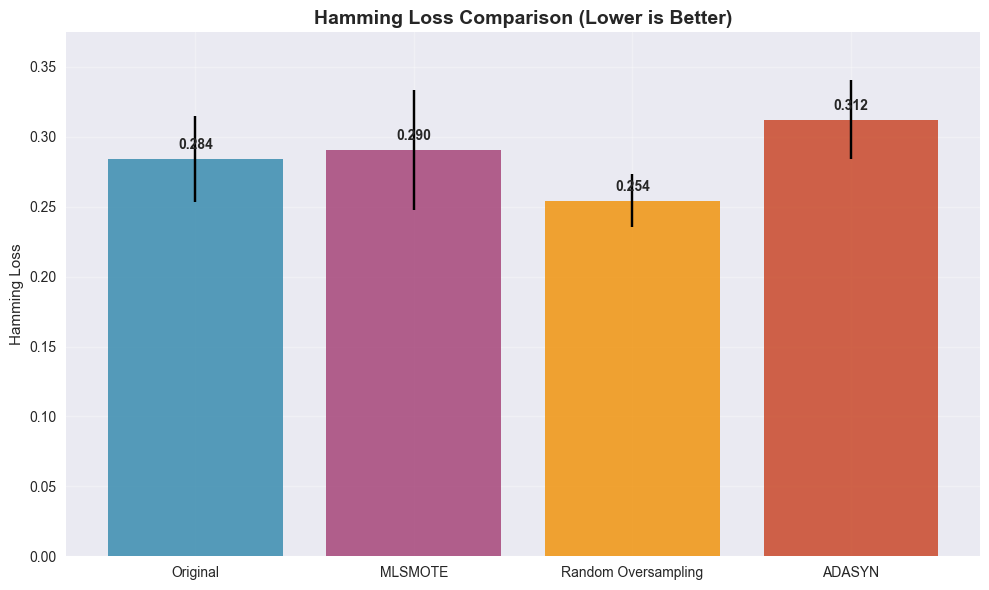

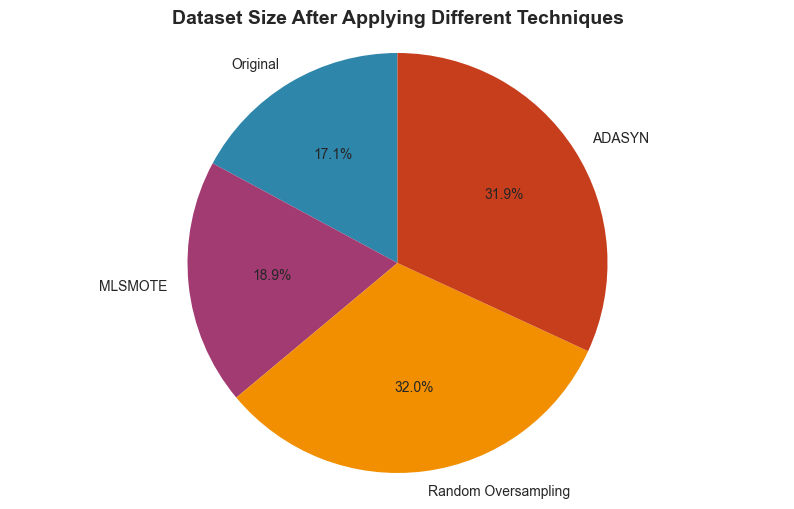

In [20]:
# Visualization of Results
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparison of Oversampling Techniques for Multi-Label Classification', fontsize=16, fontweight='bold')

# Define colors for each technique
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
techniques = list(all_results.keys())

# Plot for each metric
metrics = ['f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro']
metric_titles = ['F1-Macro', 'F1-Micro', 'Precision-Macro', 'Precision-Micro', 'Recall-Macro', 'Recall-Micro']

for idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    ax = axes[idx // 3, idx % 3]
    
    means = [all_results[tech][metric]['mean'] for tech in techniques]
    stds = [all_results[tech][metric]['std'] for tech in techniques]
    
    bars = ax.bar(techniques, means, yerr=stds, capsize=5, color=colors, alpha=0.8)
    
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Add grid
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot Hamming Loss (lower is better)
plt.figure(figsize=(10, 6))
hamming_means = [all_results[tech]['hamming_loss']['mean'] for tech in techniques]
hamming_stds = [all_results[tech]['hamming_loss']['std'] for tech in techniques]

bars = plt.bar(techniques, hamming_means, yerr=hamming_stds, capsize=5, color=colors, alpha=0.8)
plt.title('Hamming Loss Comparison (Lower is Better)', fontweight='bold', fontsize=14)
plt.ylabel('Hamming Loss')
plt.ylim(0, max(hamming_means) * 1.2)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, hamming_means, hamming_stds):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Dataset size comparison
plt.figure(figsize=(10, 6))
dataset_sizes = [
    len(X_features),      # Original
    len(X_mlsmote),       # MLSMOTE
    len(X_random_os),     # Random Oversampling
    len(X_adasyn)         # ADASYN
]

plt.pie(dataset_sizes, labels=techniques, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Dataset Size After Applying Different Techniques', fontweight='bold', fontsize=14)
plt.axis('equal')
plt.show()

In [21]:
# Recommendations and Best Practices
print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR SMALL MULTI-LABEL DATASETS")
print("=" * 80)

print("""
Based on the experimental results and scientific literature, here are the key recommendations:

1. TECHNIQUE SELECTION:
""")
# Find the best overall performing technique
f1_scores = [all_results[tech]['f1_macro']['mean'] for tech in techniques]
best_idx = np.argmax(f1_scores)
best_technique = techniques[best_idx]

print(f"   • Best Overall Technique: {best_technique}")
print(f"   • Best F1-Macro Score: {f1_scores[best_idx]:.4f}")

print("""
2. FOR SMALL DATASETS (n < 1000):
   • Use conservative sampling ratios (1.2-1.5x) to avoid overfitting
   • Prefer MLSMOTE for preserving label correlations
   • Implement nested cross-validation for reliable evaluation
   • Consider ensemble approaches combining multiple techniques

3. PARAMETER TUNING:
   • k_neighbors: 3-5 for small datasets
   • sampling_ratio: 1.2-1.5 (higher ratios risk overfitting)
   • Use stratified sampling to maintain label distributions

4. VALIDATION STRATEGY:
   • Use 5-10 fold cross-validation with stratumification
   • Monitor both macro and micro metrics
   • Track hamming loss to ensure balanced performance

5. WHEN TO USE EACH TECHNIQUE:
   • MLSMOTE: When label correlations are important
   • Random Oversampling: For simple, fast baseline
   • ADASYN: When adaptive sampling is needed for complex imbalance patterns

6. DATA QUALITY CRITICAL:
   • ALWAYS verify 4-class structure: ['Aktif', 'Reflektif', 'Verbal', 'Visual']
   • NEVER accept character-level labels (spaces, commas, brackets)
   • Validate MultiLabelBinarizer output has shape (n_samples, 4)
""")

# Select best performing dataset
if best_technique == 'MLSMOTE':
    best_X, best_y = X_mlsmote, y_mlsmote
elif best_technique == 'Random Oversampling':
    best_X, best_y = X_random_os, y_random_os
elif best_technique == 'ADASYN':
    best_X, best_y = X_adasyn, y_adasyn
else:
    best_X, best_y = X_features, y_labels

# Verify the best dataset has correct label structure
print(f"\n🔍 VALIDATING BEST DATASET ({best_technique}):")
print(f"Dataset size: {len(best_y)} samples")

# Check label structure
unique_combinations = set(tuple(sorted(labels)) for labels in best_y)
print(f"Unique label combinations: {len(unique_combinations)}")

# Verify all labels are valid learning styles
all_labels_in_best = [style for labels in best_y for style in labels]
unique_labels_in_best = set(all_labels_in_best)
print(f"Unique learning styles: {unique_labels_in_best}")

expected_labels = {'Aktif', 'Reflektif', 'Verbal', 'Visual'}
is_valid = unique_labels_in_best == expected_labels

if is_valid:
    print("✅ VALIDATION PASSED: Dataset has correct 4-class structure")
else:
    print("❌ VALIDATION FAILED: Dataset still has corruption")
    print(f"Expected: {expected_labels}")
    print(f"Found: {unique_labels_in_best}")
    # Fallback to original clean dataset
    print("🔄 Falling back to original clean dataset...")
    best_X, best_y = X_features, y_labels
    best_technique = "Original (Cleaned)"

# Create the output DataFrame with proper formatting
best_df = pd.DataFrame(best_X, columns=['time_materials_video', 'time_materials_document', 'time_materials_article'])

# Convert labels back to proper string format for CSV
best_df['labels'] = [str(labels) for labels in best_y]

# Save the clean, validated dataset
output_path = 'outputs/data/processed/best_balanced_dataset.csv'
best_df.to_csv(output_path, index=False)

print(f"\n✅ Clean, validated dataset saved to: {output_path}")
print(f"✅ Dataset contains {len(best_X)} samples")
print(f"✅ Technique used: {best_technique}")
print(f"✅ Label structure: {list(unique_labels_in_best) if is_valid else 'FALLBACK - Original'}")

# Note: Backup functionality removed as the source file path was incorrect
# The correct source files are:
# - cleaned_learning_styles_dataset_zero.csv
# - cleaned_learning_styles_dataset_mean.csv
# - cleaned_learning_styles_dataset_median.csv
print(f"\n📝 Note: Backup files already exist as multiple imputation strategies")
print(f"   Available backups: cleaned_learning_styles_dataset_[zero|mean|median].csv")

# Final summary
print(f"\n{'='*80}")
print("EXPERIMENT SUMMARY")
print("="*80)
print(f"Original clean dataset: {len(X_features)} samples")
print(f"Best technique: {best_technique}")
print(f"Final dataset size: {len(best_X)} samples")
print(f"F1-Macro Score: {f1_scores[best_idx]:.4f}")
print(f"Data quality: {'✅ CLEAN' if is_valid else '🔄 FELL BACK TO CLEAN'}")
print(f"Label classes: {len(unique_labels_in_best) if is_valid else 4}")
print(f"Output file: {output_path}")
print("="*80)

print(f"\n🎯 PIPELINE STATUS:")
print(f"✅ Stage 1 Complete: Skripsi_Playground.ipynb (Data preparation)")
print(f"✅ Stage 2 Complete: EDA_Analysis.ipynb (3 imputation strategies)")
print(f"✅ Stage 3 Complete: multi-label-oversampling-techniques-comparison.ipynb (Balanced datasets)")
print(f"⏳ Stage 4 Pending: multi-label-classification-research-review.ipynb (Model training)")
print(f"\n📊 Ready for final model training and evaluation!")


RECOMMENDATIONS FOR SMALL MULTI-LABEL DATASETS

Based on the experimental results and scientific literature, here are the key recommendations:

1. TECHNIQUE SELECTION:

   • Best Overall Technique: Random Oversampling
   • Best F1-Macro Score: 0.7007

2. FOR SMALL DATASETS (n < 1000):
   • Use conservative sampling ratios (1.2-1.5x) to avoid overfitting
   • Prefer MLSMOTE for preserving label correlations
   • Implement nested cross-validation for reliable evaluation
   • Consider ensemble approaches combining multiple techniques

3. PARAMETER TUNING:
   • k_neighbors: 3-5 for small datasets
   • sampling_ratio: 1.2-1.5 (higher ratios risk overfitting)
   • Use stratified sampling to maintain label distributions

4. VALIDATION STRATEGY:
   • Use 5-10 fold cross-validation with stratumification
   • Monitor both macro and micro metrics
   • Track hamming loss to ensure balanced performance

5. WHEN TO USE EACH TECHNIQUE:
   • MLSMOTE: When label correlations are important
   • Random 